In [33]:
# Стандартна бібліотека
import os
import sys
import time
import itertools
import json
import random
from pathlib import Path
from typing import Union
from dataclasses import dataclass
from collections import defaultdict, Counter
from typing import Any, Dict, List, Optional, Tuple
import zipfile

# Наукові обчислення та табличні дані
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Візуалізація
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

# Комп'ютерний зір та зображення
import cv2
from PIL import Image
from IPython.display import display

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.nn.utils import clip_grad_norm_
from torch.cuda.amp import autocast, GradScaler

# Аугментації
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Перевірка CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"torch current device: {torch.cuda.current_device()}")
print(f"Training device: {device}")

PyTorch version: 2.10.0+cu130
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060
CUDA version: 13.0
torch current device: 0
Training device: cuda:0


In [34]:
# Project root directory
PROJECT_ROOT = Path.cwd()

# Data directories
DATA_DIR = PROJECT_ROOT / "data"
TRAIN_DIR = DATA_DIR / "train" / "train"
TRAIN_CLEANED_DIR = DATA_DIR / "train_cleaned" / "train_cleaned"
TEST_DIR = DATA_DIR / "test" / "test"
SAMPLE_SUBMISSION_CSV = DATA_DIR / "sampleSubmission.csv"


def recursive_unzip(zip_path: Union[str, Path], extract_to: Union[str, Path] = None, remove_after: bool = False) -> None:
    zip_path = Path(zip_path)
    
    if not zip_path.exists():
        raise FileNotFoundError(f"Zip file not found: {zip_path}")
    
    if not zipfile.is_zipfile(zip_path):
        raise ValueError(f"File is not a valid zip file: {zip_path}")
    
    # Determine extraction directory
    if extract_to is None:
        extract_to = zip_path.parent / zip_path.stem
    else:
        extract_to = Path(extract_to)
    
    # Create extraction directory if it doesn't exist
    extract_to.mkdir(parents=True, exist_ok=True)
    
    print(f"Extracting {zip_path} to {extract_to}")
    
    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    
    # Remove the zip file if requested
    if remove_after:
        zip_path.unlink()
        print(f"Removed {zip_path}")
    
    # Find all zip files in the extracted directory and recursively extract them
    for item in extract_to.rglob('*.zip'):
        if item.is_file() and zipfile.is_zipfile(item):
            # Recursively extract nested zip files
            nested_extract_to = item.parent / item.stem
            recursive_unzip(item, nested_extract_to, remove_after=remove_after)

recursive_unzip('denoising-dirty-documents.zip', extract_to='data/')

Extracting denoising-dirty-documents.zip to data
Extracting data/sampleSubmission.csv.zip to data/sampleSubmission.csv
Extracting data/train.zip to data/train
Extracting data/train_cleaned.zip to data/train_cleaned
Extracting data/test.zip to data/test


In [35]:
class DenoisingDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir=None, transforms=None):
        self.noisy_dir = Path(noisy_dir)
        self.clean_dir = Path(clean_dir) if clean_dir is not None else None
        self.filenames = sorted([p.name for p in self.noisy_dir.iterdir() if p.suffix.lower() in ('.png', '.jpg', '.jpeg')])
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        noisy_path = self.noisy_dir / fname
        noisy = cv2.imread(str(noisy_path), cv2.IMREAD_COLOR)[:, :, ::-1]  # BGR->RGB
        noisy = noisy.astype('float32') / 255.0

        if self.clean_dir is not None and (self.clean_dir / fname).exists():
            clean = cv2.imread(str(self.clean_dir / fname), cv2.IMREAD_COLOR)[:, :, ::-1].astype('float32') / 255.0
        else:
            clean = noisy.copy()

        if self.transforms is not None:
            # albumentations expects uint8 images; convert back if needed
            augmented = self.transforms(image=(noisy * 255).astype('uint8'), mask=None)
            noisy_aug = augmented['image'].astype('float32') / 255.0
            noisy = noisy_aug

        # HWC -> CHW and to torch.tensor
        noisy_t = torch.from_numpy(noisy.transpose(2, 0, 1)).float()
        clean_t = torch.from_numpy(clean.transpose(2, 0, 1)).float()

        return {'noisy': noisy_t, 'clean': clean_t, 'fname': fname}

Dataset size: 144


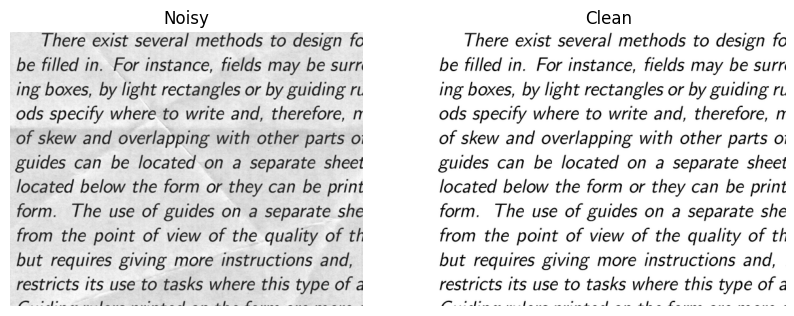

In [36]:
# Demo: create dataset, dataloader and display a sample
# Minimal transforms (optional)
basic_transforms = None

# Instantiate dataset (uses TRAIN_DIR and TRAIN_CLEANED_DIR from earlier cell)
dataset = DenoisingDataset(TRAIN_DIR, TRAIN_CLEANED_DIR, transforms=basic_transforms)
print('Dataset size:', len(dataset))

# Small DataLoader for demo
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

# Display one noisy/clean pair
if len(dataset) > 0:
    sample = dataset[0]
    noisy = sample['noisy'].permute(1,2,0).numpy()
    clean = sample['clean'].permute(1,2,0).numpy()
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Noisy')
    plt.imshow(np.clip(noisy, 0, 1))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Clean')
    plt.imshow(np.clip(clean, 0, 1))
    plt.axis('off')
    plt.show()
else:
    print('No images found in', TRAIN_DIR)